# Escansão de versos usando modelo SEQ2SEQ.
### Notebook por Pedro Esteves <br>
Código baseado e adaptado de: <br>
https://keras.io/examples/nlp/lstm_seq2seq/  (modelo LSTM original)<br>
https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras (encoder BLSTM) <br>
https://natura.di.uminho.pt/download/sources/Dictionaries/wordlists/ (Lista de palavras usadas para treinar o modelo) <br>



# 2 Problemas

### Contagem de sílabas:


### <b>Classificação da sílaba tónica: </b>

Algo que aprendemos durante a escola no ensino básico foi a classificação de palavras quanto à sua sílaba tónica. Na língua portuguesa cada palavra pode ser:

<p><font color='red'>- Aguda (se a sílaba tónica for última sílaba) </p>
Ex: In|<b>ês</b>|

<p><font color='green'>- Grave (se sílaba tónica for a penúltima sílaba) <font/> </p>
Ex: a<b>|do</b>|ra|<p>

<p><font color='blue'>-  Exdrúxula (se a sílaba tónica for a antepenúltima sílaba da palavra) </p>
Ex: Ma|te<b>|má|</b>ti|ca|

<p style="color:red"><b> NÃO EXISTEM PALAVRAS COM A SÍLABA TÓNICA NA ANTE-ANTEPENÚLTIMA SÍLABA!</b> </p>

Para executarmos a escansão de versos precisamos de ter em conta a seguintes regras:
- Contar o número de sílabas de cada verso até à última sílaba tónica da última palavra do verso.
<p><b>Ex 1:</b> <font color="brown"> "As armas e os barões assinalados..." -> As| ar|mas| eos| ba|rões| a|ssi|na|<b>la</b>...</p></font>

  Caso contássemos todas as sílabas, o verso acima teria 11, mas como se conta apenas até à sílaba tónica da última palavra, apenas temos 10.<br> 



- Se a última letra duma palavra for uma vogal átona e a primeira letra da primeira sílaba da palavra seguinte (no mesmo verso) for uma vogal ou um h mudo contam-se estas duas sílabas apenas como uma (sinalefa): 
 <p><b>Ex 2:</b> <font color="brown"> "Se a tanto me ajudar o engenho e arte..." -> <b>Sea</b>| tan|to| <b>mea</b>|ju|dar| <b>oen</b>|ge|nhoear| </p> </font>

 "e" funde-se com "os" e conta apenas como uma sílaba: "eos" </p>


In [1]:
 sea$ tan$to| mea|ju|dar$ oen|ge$nhoe$ ar$te| 

In [2]:
from google.colab import drive
drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/syllabe_model"

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import copy
import random
os.getcwd()

'/content'

In [4]:
batch_size = 64 # Batch size for training.
epochs = 8  # Number of epochs to train for.
latent_dim = 1024  # Latent dimensionality of the encoding space.
num_samples = 120000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path ="/content/dados_escansao.txt"


In [8]:
def process_line(line):
  line = line.lower()
  for c in ['\x83', '\xa0', '¢', '£', '§', '©', 'ª', '\xad', '®', '³', '´', 'µ', 'º', 'Â', 'Ã','\x81', '\x8d', '\x93']:
    line = line.replace(c,"")
  return line

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    new_lines = copy.deepcopy(lines)
    for l in lines:
      if len(l) <= 7 or l[0:9] == "desigual	" or l.split("\t")[0] == "igual" or l.split("\t")[0] == "qual":
        for x in range(0,3):
          new_lines.append(l)
    lines = new_lines

for line in lines[: min(num_samples, len(lines) - 1)]:
    line = process_line(line)
    input_text, target_text = line.split("\t")

    input_text = input_text.strip()
    target_text = target_text.strip()
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    #encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    #decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    #decoder_target_data[i, t:, target_token_index[" "]] = 1.0
print(input_characters)
print(target_characters)

Number of samples: 120000
Number of unique input tokens: 40
Number of unique output tokens: 42
Max sequence length for inputs: 28
Max sequence length for outputs: 41
['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'á', 'â', 'ã', 'ç', 'é', 'ê', 'í', 'î', 'ó', 'ô', 'õ', 'ú']
['\t', '\n', '$', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', 'à', 'á', 'â', 'ã', 'ç', 'é', 'ê', 'í', 'ó', 'ô', 'õ', 'ú']


In [9]:
from keras.layers import LSTM, Bidirectional,Concatenate,Input,Dense

#Encoder
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = Bidirectional(LSTM(latent_dim, return_state=Trues))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]


#Decoder
n_output=num_decoder_tokens
decoder_inputs = Input(shape=(None, num_decoder_tokens))    
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(n_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)



In [10]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)


#model = keras.models.load_model(model_path)


#treina o modelo
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size, #batch_size,
    epochs=epochs, #epochs,
    validation_split=0.2,
)

# Save model
model_path = "drive/MyDrive/contador_de_silabas_metricas/"
model.save(model_path)
model_path = "drive/MyDrive/contador_de_silabas_metricas_final/"
model.save(model_path)

model_path = "drive/MyDrive/contador_de_silabas_metricas_backup/"
model.save(model_path)

Epoch 1/8
1500/1500 [==============================] - 242s 139ms/step - loss: 0.9417 - accuracy: 0.1350 - val_loss: 0.0494 - val_accuracy: 0.3862
Epoch 2/8
1500/1500 [==============================] - 213s 142ms/step - loss: 0.0515 - accuracy: 0.3828 - val_loss: 0.0078 - val_accuracy: 0.3933
Epoch 3/8
1500/1500 [==============================] - 212s 141ms/step - loss: 0.0126 - accuracy: 0.3911 - val_loss: 0.0052 - val_accuracy: 0.3937
Epoch 4/8
1500/1500 [==============================] - 211s 141ms/step - loss: 0.0067 - accuracy: 0.3930 - val_loss: 0.0033 - val_accuracy: 0.3941
Epoch 5/8
1500/1500 [==============================] - 211s 141ms/step - loss: 0.0037 - accuracy: 0.3941 - val_loss: 0.0026 - val_accuracy: 0.3943
Epoch 6/8
1500/1500 [==============================] - 210s 140ms/step - loss: 0.0028 - accuracy: 0.3932 - val_loss: 0.0019 - val_accuracy: 0.3944
Epoch 7/8
1500/1500 [==============================] - 210s 140ms/step - loss: 0.0025 - accuracy: 0.3937 - val_loss: 0

INFO:tensorflow:Assets written to: drive/MyDrive/contador_de_silabas_metricas/assets


INFO:tensorflow:Assets written to: drive/MyDrive/contador_de_silabas_metricas/assets


INFO:tensorflow:Assets written to: drive/MyDrive/contador_de_silabas_metricas_final/assets


INFO:tensorflow:Assets written to: drive/MyDrive/contador_de_silabas_metricas_final/assets


INFO:tensorflow:Assets written to: drive/MyDrive/contador_de_silabas_metricas_backup/assets


INFO:tensorflow:Assets written to: drive/MyDrive/contador_de_silabas_metricas_backup/assets


In [11]:
model_path = "drive/MyDrive/contador_de_silabas_metricas/"
#model.save(model_path)
model = keras.models.load_model(model_path)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


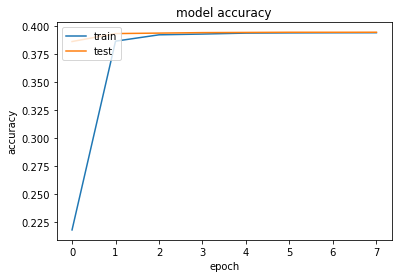

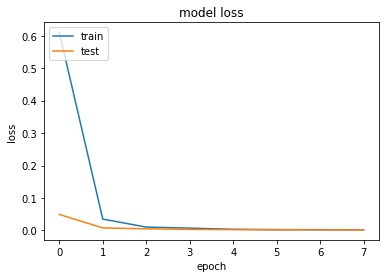

In [12]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(model_path)

In [ ]:
#loads model
#model = keras.models.load_model(model_path)


In [ ]:
model.summary()

In [ ]:
model.input[0]

In [243]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
#model = keras.models.load_model("s2s")

# define inference encoder
encoder_model = keras.Model(encoder_inputs, encoder_states)
# define inference decoder
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        #print("output_tokens:",output_tokens.shape)
        #print("h:",h.shape)
        #print("c",c.shape)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        #print("sampled char:",sampled_char)
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [310]:
import re

#Faz predict duma palavra a minha escolha.
def encode_word(input_text):
    input_encoded = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

    for t, char in enumerate(input_text):
      input_encoded[0, t, input_token_index[char]] = 1.0
    return input_encoded

#Faz predict duma palavra a minha escolha.
def encode_data(input_text):
    input_encoded = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

    for t, char in enumerate(input_text):
      input_encoded[0, t, input_token_index[char]] = 1.0
    return input_encoded

poemas = [
#versos decassilábicos
["As armas e os barões assinalados,",
"Que da ocidental praia Lusitana,",
"Por mares nunca de antes navegados,",
"Passaram ainda além da Taprobana,",
"Em perigos e guerras esforçados,",
"Mais do que prometia a força humana,",
"E entre gente remota edificaram",
"Novo Reino, que tanto sublimaram;"],

[
 "E também as memórias gloriosas",
"Daqueles Reis, que foram dilatando",
"A Fé, o Império, e as terras viciosas",
"De África e de Ásia andaram devastando;",
"E aqueles, que por obras valerosas",
"Se vão da lei da morte libertando;",
"Cantando espalharei por toda parte,",
"Se a tanto me ajudar o engenho e arte."
],
[
"Cessem do sábio Grego e do Troiano",
"As navegações grandes que fizeram;",
"Cale-se de Alexandro e de Trajano",
"A fama das vitórias que tiveram;",
"Que eu canto o peito ilustre Lusitano,",
"A quem Neptuno e Marte obedeceram:",
"Cesse tudo o que a Musa antígua canta,",
"Que outro valor mais alto se alevanta."
],
["E vós, Tágides minhas, pois criado",
"Tendes em mim um novo engenho ardente",
"Se sempre em verso humilde celebrado",
"Foi de mim vosso rio alegremente,",
"Dai-me agora um som alto e sublimado,",
"Um estilo grandíloquo e corrente,",
"Porque de vossas águas, Febo ordene",
"Que não tenham inveja às de Hipocrene."],

["Dai-me uma fúria grande e sonorosa",
"E não de agreste avena ou frauta ruda",
"Mas de tuba canora e belicosa",
"Que o peito acende e a cor ao gesto muda;",
"Dai-me igual canto aos feitos da famosa",
"Gente vossa, que a Marte tanto ajuda;",
"Que se espalhe e se cante no universo,",
"Se tão sublime preço cabe em verso."],

["E vós, ó bem nascida segurança",
"Da Lusitana antígua liberdade,",
"E não menos certíssima esperança",
"De aumento da pequena Cristandade;",
"Vós, ó novo temor da Maura lança,",
"Maravilha fatal da nossa idade,",
"Dada ao mundo por Deus, que todo o mande,",
"Para do mundo a Deus dar parte grande;",],

["Vós, tenro e novo ramo florescente",
"De uma árvore de Cristo mais amada",
"Que nenhuma nascida no Ocidente,",
"Cesárea ou Cristianíssima chamada;",
"(Vede-o no vosso escudo, que presente",
"Vos amostra a vitória já passada,",
"Na qual vos deu por armas, e deixou",
"As que Ele para si na Cruz tomou)"],

["Vós, poderoso Rei, cujo alto Império",
"O Sol, logo em nascendo, vê primeiro;",
"Vê-o também no meio do Hemisfério,",
"E quando desce o deixa derradeiro;",
"Vós, que esperamos jugo e vitupério",
"Do torpe Ismaelita cavaleiro,",
"Do Turco oriental, e do Gentio,",
"Que inda bebe o licor do santo rio;"],

#heptassílabos
["O poeta é um fingidor",
"Finge tão completamente",
"Que chega a fingir que é dor",
"A dor que deveras sente"],

#decassilabos
["Alma minha gentil que te partiste",
 "tão cedo desta vida descontente",
 "repousa lá no céu eternamente",
 "e viva eu cá na terra sempre triste"]]

vogais_atonas =["a","e","i","o","u"]
vogais = ["à","á","a","e","i","o","u","h","é"] 
conectores = ["se","que","o","a","e","as","os","da","de","do","das","de","das","na","no","na","nos","em","me"]

def ends_in_vogal(syllabe):
  syllabe = syllabe[0]
  if syllabe[-1] in vogais_atonas: return True
  else: return False

def starts_with_vocal(syllabe):
  if syllabe == []: return False
  syllabe =syllabe[0]
  if syllabe[0] in vogais: return True
  else: return False

def process_decoded_seq(seq,word):
  seq = seq.replace("||","|").strip()
  if len(seq) == len(word) and len(seq) < 3:
    seq = word + "$"
  for ele in ["$|","|$"]:
    seq = seq.replace(ele,"$")
  seq = re.sub('\$+', "$",seq)
  seq = re.sub('\|+', "|",seq)
  seq = seq.replace("de|o","deo")
  return seq

def remove_last_separator(verse):
  verse = verse[::-1]
  saw_space = False
  for ind in range(0,len(verse)):
    if verse[ind] == " ":
      saw_space = True

    if saw_space == True and (verse[ind] == "|" or verse[ind] == "$"):
      res = verse[0:ind].strip() + verse[ind + 1:len(verse)].strip()
      return res[::-1]
  return verse[::-1].strip()

#se a silaba terminar em vogal e
#se estiver na ultima silaba da palavra e
#ultima silaba for atona ou se a palavra for um conetor
def check_sinalefa(metric_syllabe,word_syllabes,processed_word,s_ind,word):
  metric_syllabe = [metric_syllabe[-1]]
  if ends_in_vogal(metric_syllabe) and s_ind == len(word_syllabes)-1\
       and (processed_word[-1] != "$" or word in conectores):
    return True
  else:
    return False


def process_verse(verse):
  processed_verse = ""
  syllabe_counter = 0
  sinalefa = False

  #itera palavras do verso
  for v_ind in range(0,len(verse)):
    processed_verse += " "
    word = verse[v_ind].strip()
    input_seq = encode_word(word)
    pre_processed_word = decode_sequence(input_seq)
    processed_word = process_decoded_seq(pre_processed_word,word)
    processed_verse += processed_word

    #divide a palavra em silabas
    word_syllabes = [x for x in processed_word.split("|") if x and x != "$"]

    #itera as silabas da palavra
    for s_ind in range(0,len(word_syllabes)):

      syllabe = word_syllabes[s_ind]

      #Procura pela silaba tonica (separador $)
      #o metric_syllabe tem dimensao 1 caso haja silaba tonica ou 2 caso nao haja
      metric_syllabe = [x for x in syllabe.split("$") if x and x]

      #Caso da ultima silaba metrica da palavra e do verso
      #adicionamos sempre uma silaba
      if v_ind == len(verse)-1 and s_ind == len(word_syllabes)-1:
        #caso do engenho-e-ar
        if sinalefa == True and starts_with_vocal(metric_syllabe) == True :
          syllabe_counter += 0
          processed_verse = remove_last_separator(processed_verse)
        else:
          syllabe_counter += 1
      else:
        if sinalefa: 
          if  starts_with_vocal(metric_syllabe):
            sinalefa = False
            syllabe_counter += len(metric_syllabe)-1
            processed_verse = remove_last_separator(processed_verse)
            sinalefa = check_sinalefa(metric_syllabe,word_syllabes,processed_word,s_ind,word)
            continue
        syllabe_counter += len(metric_syllabe)        
      #print("metric syllabe iterada:",metric_syllabe)
      sinalefa = check_sinalefa(metric_syllabe,word_syllabes,processed_word,s_ind,word)


  return syllabe_counter,processed_verse

def prepare_verse(verse):
  for ele in [",",";",".",":",")","("]:
    verse = verse.replace(ele,"")
  tokens = verse.split()
  for ind in range(0,len(tokens)):
      verse = " ".join(tokens)
  return verse.lower().split()


In [285]:

#Recebe 1 hot vector, retorna carater
def get_input_char(embedding):
  print(embedding)
  print(input_characters)
  for ind in range(0,len(embedding)):
    if int(embedding[ind]) == 1:
      return input_characters[ind]


#input_seq = encode_data("severo")
input_seq = encode_data("ásia")
word = decode_sequence(input_seq)
print(word)

á$sia|



In [312]:
for versos in poemas:
  for original_verse in versos:
    verse = prepare_verse(original_verse)
    metric_syllabe_counter,processed_verse = process_verse(verse)
    print("--------------------------------------------")
    print("Verso orig: {}".format(original_verse))
    print("Verso proc: {} , Sílabas Métricas: {}".format(processed_verse,metric_syllabe_counter))
  print("#########################################################")


--------------------------------------------
Verso orig: As armas e os barões assinalados,
Verso proc: as$ ar$mas| eos$ ba|rões$ as|si|na|la$dos| , Sílabas Métricas: 10
--------------------------------------------
Verso orig: Que da ocidental praia Lusitana,
Verso proc: que$ dao|ci|den|tal$ prai$a| lu|si|ta$na| , Sílabas Métricas: 10
--------------------------------------------
Verso orig: Por mares nunca de antes navegados,
Verso proc: por$ ma$res| nun$ca| dean$tes| na|ve|ga$dos| , Sílabas Métricas: 10
--------------------------------------------
Verso orig: Passaram ainda além da Taprobana,
Verso proc: pas|sa$ram| ain$daa|lém$ da| ta|pro|ba$na| , Sílabas Métricas: 10
--------------------------------------------
Verso orig: Em perigos e guerras esforçados,
Verso proc:  em$ pe|ri$gos| e$ guer$ras| es|for|ça$dos| , Sílabas Métricas: 10
--------------------------------------------
Verso orig: Mais do que prometia a força humana,
Verso proc: mais$ do$ que$ pro|me|ti$aa$ for$çahu|ma$na| , 